# PROCESAMIENTO DE IMAGENES Y VISION POR COMPUTADORA

Autor: Serafini, MArtin Nicolas

Abril 2025

## CARGA DE LA IMAGEN

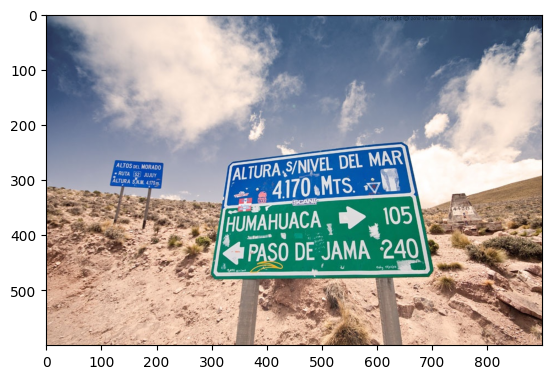

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import io

# Cargo la imagen
url = 'https://i.pinimg.com/1200x/06/36/b6/0636b604f028a8509d41fa07617270c4.jpg'
response = requests.get(url, stream=True).content
img = cv2.imdecode(np.frombuffer(response, np.uint8), cv2.IMREAD_COLOR)

# Como esta nativamente cargada en BGR la paso a RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
img.shape

(600, 900, 3)

## CAMBIO DE PERSPECTIVA (cv2)

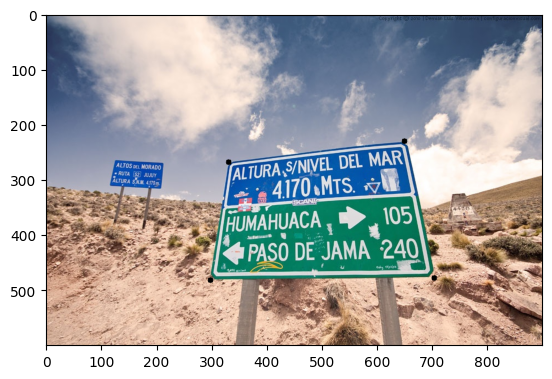

In [ ]:
# Coordenadas x,y de los vertices
corners = [(331,268), # Superior izquierdo
           (650,230), # Inferior izquierdo
           (298,482), # Superior derecho
           (704,478) # Inferior derecho
          ]
# Marco los vertices para tener las referencias
for x, y in corners:
    cv2.circle(img, (x,y), radius=0, color=(0, 0, 0), thickness=10)
plt.imshow(img);

In [ ]:
# Determino el tamaño que va a tener la imagen corregida (la agrando un 5% aproximadamente)
w, h = 609, 378

In [ ]:
pts1 = np.float32(corners)
# Para los puntos de destino, debe preservarse el orden de los puntos originales
pts2 = np.float32([[0, 0], [w, 0], [0, h], [w, h]])

In [ ]:
# Obtenemos la matriz de cambio de perspectiva
matrix = cv2.getPerspectiveTransform(pts1, pts2)

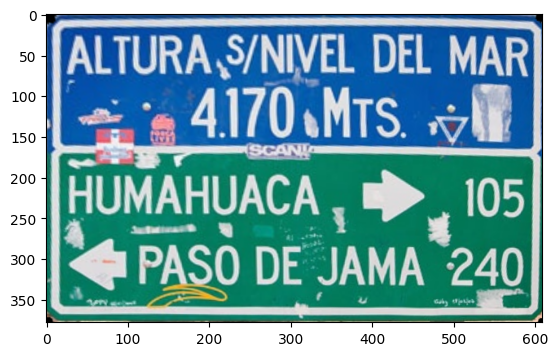

In [ ]:
# Y la aplicamos con warpPerspective
# El segundo parametro es esta matriz de transformacion obtenida en getPerspectiveTransform y el tercero debe ser una tupla con especificando (ancho, alto)
img_output = cv2.warpPerspective(img, matrix, (w, h))
plt.imshow(img_output);

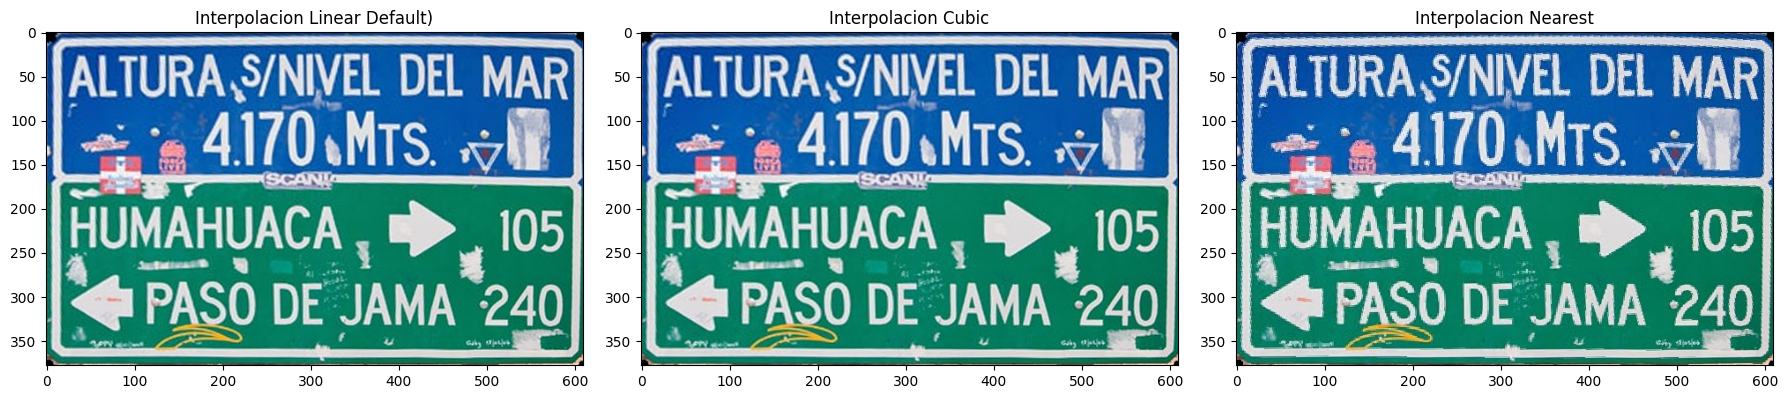

In [ ]:
# Por defecto la interpolacion es LINEAR, PRUEBO NEAREST Y CUBIC
img_output_cubic = cv2.warpPerspective(img, matrix, (w, h), flags=cv2.INTER_CUBIC)
img_output_nearest = cv2.warpPerspective(img, matrix, (w, h), flags=cv2.INTER_NEAREST)

# Muestro la comparativa
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].imshow(img_output_cubic)
axes[0].set_title('Interpolacion Linear Default)')
axes[1].imshow(img_output_cubic)
axes[1].set_title('Interpolacion Cubic')
axes[2].imshow(img_output_nearest)
axes[2].set_title('Interpolacion Nearest')
plt.tight_layout()
plt.show()

## RECORTE

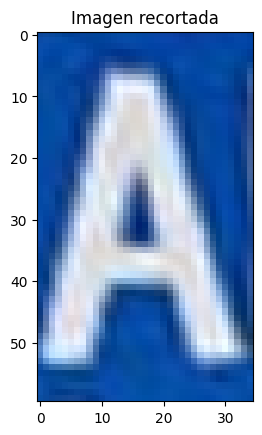

In [ ]:
# Defino las coordenadas del recorte
x_start = 25  # Coordenada x inicial del recorte
y_start = 20   # Coordenada y inicial del recorte
ancho = 35   # Ancho del recorte
alto = 60   # Alto del recorte

# Recorta la imagen
recorte = img_output_cubic[y_start:y_start + alto, x_start:x_start + ancho]

# Muestra la imagen recortada
plt.imshow(recorte)
plt.title('Imagen recortada')
plt.show()


### cv2.Canny

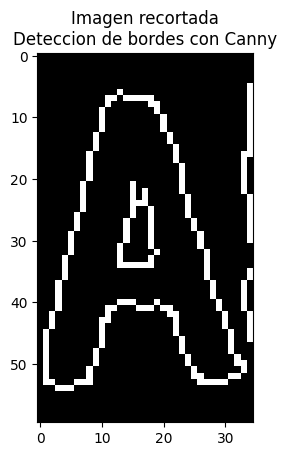

In [ ]:
recorte_gris = cv2.cvtColor(recorte, cv2.COLOR_BGR2GRAY)
recorte_bordes_canny2 = cv2.Canny(recorte_gris, 50, 160)

plt.imshow(recorte_bordes_canny2, cmap='gray')
plt.title('Imagen recortada\nDeteccion de bordes con Canny')
plt.show()

## INTERPOLACION

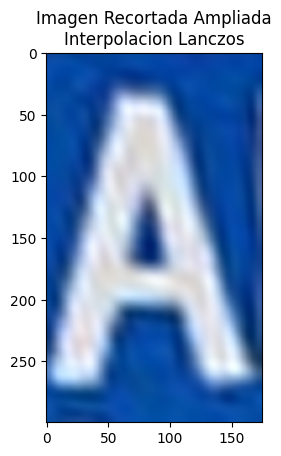

In [ ]:
# Amplio el recorte 5 veces e interpolo usando Lanczos, demanda mas costo computacional pero los resultados son mejores
recorte_ampliado = cv2.resize(recorte, (ancho*5, alto*5), interpolation=cv2.INTER_LANCZOS4)
plt.imshow(recorte_ampliado)
plt.title('Imagen Recortada Ampliada\nInterpolacion Lanczos')
plt.show()

### cv2.Canny

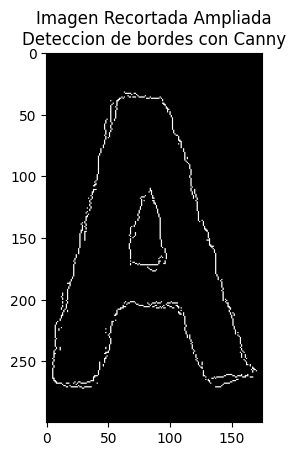

In [ ]:
recorte_amp_gris = cv2.cvtColor(recorte_ampliado, cv2.COLOR_BGR2GRAY)
recorte_bordes_canny = cv2.Canny(recorte_amp_gris, 50, 100)

plt.imshow(recorte_bordes_canny, cmap='gray')
plt.title('Imagen Recortada Ampliada\nDeteccion de bordes con Canny')
plt.show()

## TEMPLATE MATCHING

Coincidencia encontrada en: (np.int64(25), np.int64(18))
Coincidencia encontrada en: (np.int64(170), np.int64(18))
Coincidencia encontrada en: (np.int64(171), np.int64(18))
Coincidencia encontrada en: (np.int64(24), np.int64(19))
Coincidencia encontrada en: (np.int64(25), np.int64(19))
Coincidencia encontrada en: (np.int64(170), np.int64(19))
Coincidencia encontrada en: (np.int64(171), np.int64(19))
Coincidencia encontrada en: (np.int64(24), np.int64(20))
Coincidencia encontrada en: (np.int64(25), np.int64(20))
Coincidencia encontrada en: (np.int64(26), np.int64(20))
Coincidencia encontrada en: (np.int64(170), np.int64(20))
Coincidencia encontrada en: (np.int64(171), np.int64(20))
Coincidencia encontrada en: (np.int64(529), np.int64(20))
Coincidencia encontrada en: (np.int64(530), np.int64(20))
Coincidencia encontrada en: (np.int64(24), np.int64(21))
Coincidencia encontrada en: (np.int64(25), np.int64(21))
Coincidencia encontrada en: (np.int64(26), np.int64(21))
Coincidencia encontrada

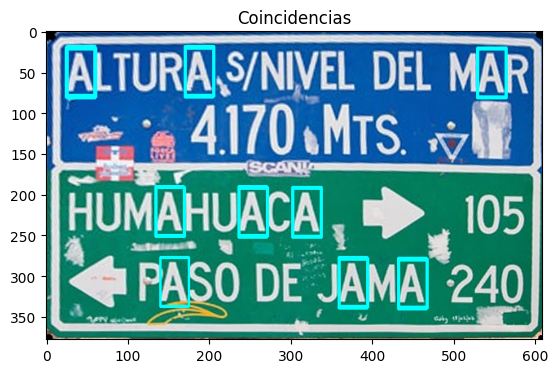

True

In [ ]:
# Trabajo con el recorte sin interpolar
# Genero el Template Matching sobre el recorte
template = recorte
# Convierto la imagen y el recorte a escala de grises para mejorar el emparejamiento
img_gray = cv2.cvtColor(img_output_cubic, cv2.COLOR_BGR2GRAY)
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
res = cv2.matchTemplate(img_gray,template_gray,cv2.TM_CCOEFF_NORMED)
umbral = 0.90
# Busco coincidencias en el array donde el % de similitud es superior al umbral
loc = np.where( res >= umbral)

# Dibujo rectangulos en las coincidencias
for pt in zip(*loc[::-1]):
    # Dibujo un rectangolo tomando las coordenadas iniciales y sumandole el ancho y alto del recorte asi queda segmentada la letra
    cv2.rectangle(img_output_cubic, pt, (pt[0] + ancho, pt[1] + alto), (0,255,255), 2)
    print(f"Coincidencia encontrada en: {pt}")

# Muestra la imagen con los rectángulos
plt.imshow(img_output_cubic)
plt.title('Coincidencias')
plt.show()

# Guardo la imagen
cv2.imwrite('img_output_cubic.jpg', cv2.cvtColor(img_output_cubic, cv2.COLOR_RGB2BGR))


La comparacion arroja varias coincidencias casi superpuestas para las distintas A (con diferencia de algunos pixeles)

## OCR

In [ ]:
!pip install easyocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [ ]:
import easyocr
reader = easyocr.Reader(['es'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
# El  metodo readtext extrae texto de la imagen
results = reader.readtext(img_output)

In [ ]:
results[0][0]

[[np.int32(16), np.int32(13)],
 [np.int32(605), np.int32(13)],
 [np.int32(605), np.int32(86)],
 [np.int32(16), np.int32(86)]]

In [ ]:
# Cada deteccion se almacena con las coordenadas de la bounding box y su probabilidad
results

[([[np.int32(16), np.int32(13)],
   [np.int32(605), np.int32(13)],
   [np.int32(605), np.int32(86)],
   [np.int32(16), np.int32(86)]],
  'ALTURA SINIVEL DEL MAR',
  np.float64(0.879622019343974)),
 ([[np.int32(169), np.int32(79)],
   [np.int32(450), np.int32(79)],
   [np.int32(450), np.int32(165)],
   [np.int32(169), np.int32(165)]],
  '4170 MTs',
  np.float64(0.5578609024472231)),
 ([[np.int32(247), np.int32(159)],
   [np.int32(313), np.int32(159)],
   [np.int32(313), np.int32(177)],
   [np.int32(247), np.int32(177)]],
  'Sce',
  np.float64(0.21435163943382998)),
 ([[np.int32(18), np.int32(185)],
   [np.int32(343), np.int32(185)],
   [np.int32(343), np.int32(257)],
   [np.int32(18), np.int32(257)]],
  'HUMAHUACA',
  np.float64(0.9848085724725114)),
 ([[np.int32(505), np.int32(193)],
   [np.int32(597), np.int32(193)],
   [np.int32(597), np.int32(259)],
   [np.int32(505), np.int32(259)]],
  '105',
  np.float64(0.9992404802659891)),
 ([[np.int32(102), np.int32(272)],
   [np.int32(598), n

In [ ]:
# El cartel presenta manchas que son asignadas como posibles lecturas
# Listo las detecciones con una probabilidad mayor al 30%
for (bbox, text, prob) in results:
    if prob > 0.3:
        print(f"Texto detectado: {text} (Probabilidad: {prob:.2f})")

Texto detectado: ALTURA SINIVEL DEL MAR (Probabilidad: 0.88)
Texto detectado: 4170 MTs (Probabilidad: 0.56)
Texto detectado: HUMAHUACA (Probabilidad: 0.98)
Texto detectado: 105 (Probabilidad: 1.00)
Texto detectado: PASO DE JAMA   2401 (Probabilidad: 0.38)


No registro la / en la primer linea.

Se genero un error de lectura 2401 en vez de 240

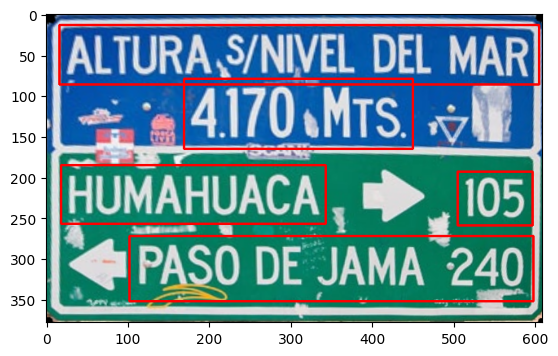

In [ ]:
# Hago recuadros en la imagen con los datos de los bounding box
for (bbox, text, prob) in results:
    if prob > 0.3:
        # Extrae las coordenadas del bounding box
        (tl, tr, br, bl) = bbox
        tl = (int(tl[0]), int(tl[1]))
        tr = (int(tr[0]), int(tr[1]))
        br = (int(br[0]), int(br[1]))
        bl = (int(bl[0]), int(bl[1]))

        # Dibuja un rectangulo alrededor de las detecciones
        cv2.rectangle(img_output, tl, br, (255, 0, 0), 2)

# Muestra la imagen
plt.imshow(img_output)
plt.show()